In [ ]:
import pandas as pd
import os

# Load the dataset from the Excel file
file_path = '/content/Copy of Active Power Load - 33_11KV - Godishala Substation .xlsx'
df = pd.read_excel(file_path)

# Define time periods based on the hour
def get_period(time_obj):
    hour = time_obj.hour  # Extract the hour from the datetime.time object
    if 4<= hour <8:
        return 'Morning'
    elif 11<= hour < 15:
        return 'Afternoon'
    elif 15 <= hour <19 :
        return 'Evening'
    elif 20<= hour <=23:
        return 'Night'

# Add a column for the period of the day
df['Period'] = df['TIME'].apply(get_period)  # Apply the modified get_period function

# Calculate statistical parameters for each period of each day
stats = df.groupby(['DATE', 'Period'])['POWER (KW)'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])

# Reset index for better readability
stats = stats.reset_index()

# Display the statistical parameters
print(stats)

# Optionally save the results to a new Excel file
output_dir = '/mnt/data'  # Extract directory from file path
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Optionally save the results to a new Excel file
output_file_path = '/content/patternpredicted.xlsx'
stats.to_excel(output_file_path, index=False)


FileNotFoundError: [Errno 2] No such file or directory: '/content/Copy of Active Power Load - 33_11KV - Godishala Substation .xlsx'

In [ ]:
print("\nFour-Hour Clusters:")
for date, group in df.groupby('DATE'):
    print(f"\nDate: {date}")
    for period, period_group in group.groupby('Period'):
        print(f"  {period}:")
        print(period_group[['TIME', 'POWER (KW)']])

# Optionally save the results to a new Excel file
output_file_path = '/mnt/data/daily_period_stats.xlsx'
with pd.ExcelWriter(output_file_path) as writer:
    stats.to_excel(writer, sheet_name='Stats', index=False)
    df.to_excel(writer, sheet_name='Clusters', index=False)

Streaming output truncated to the last 5000 lines.
4133  06:00:00  1637.078998
4134  07:00:00  1898.500890
  Night:
          TIME   POWER (KW)
4147  20:00:00  1081.977498
4148  21:00:00  1062.656472
4149  22:00:00   985.372365
4150  23:00:00   927.409284

Date: 2021-06-23 00:00:00
  Afternoon:
          TIME   POWER (KW)
4162  11:00:00  1653.623547
4163  12:00:00  1614.714758
4164  13:00:00  1706.998425
4165  14:00:00  1589.274395
  Evening:
          TIME   POWER (KW)
4166  15:00:00  1453.259910
4167  16:00:00  1529.747273
4168  17:00:00  1567.990955
4169  18:00:00  1556.351574
  Morning:
          TIME   POWER (KW)
4155  04:00:00  1300.285182
4156  05:00:00  1554.356251
4157  06:00:00  1578.300121
4158  07:00:00  1778.331205
  Night:
          TIME   POWER (KW)
4171  20:00:00  1137.998950
4172  21:00:00  1060.846479
4173  22:00:00   964.405890
4174  23:00:00   887.253418

Date: 2021-06-24 00:00:00
  Afternoon:
          TIME   POWER (KW)
4186  11:00:00  1523.771698
4187  12:00:00  1

In [ ]:
!pip install pandas openpyxl numpy

In [ ]:
import pandas as pd
import numpy as np

# Load the data
file_path = '/content/errors clusters.xlsx'
df = pd.read_excel(file_path)

# Convert the 'time' column to datetime format and extract only the time part
df['time'] = pd.to_datetime(df['time']).dt.time

# Define the periods of the day
def get_period(time_obj):
    hour = time_obj.hour
    if 4 <= hour < 8:
        return 'Morning'
    elif 11 <= hour < 15:
        return 'Afternoon'
    elif 15 <= hour < 19:
        return 'Evening'
    elif 20 <= hour <= 23:
        return 'Night'
    else:
        return 'Other'

# Add a column for the period of the day
df['Period'] = df['time'].apply(get_period)

# Calculate MAE for each period of each day
def calculate_mae(group):
    mae = np.mean(np.abs(group['Actual Value'] - group['Predicted value']))
    return mae

mae_results = df.groupby(['date', 'Period']).apply(calculate_mae).reset_index(name='MAE')

# Filter out the 'Other' period as it is not needed
mae_results = mae_results[mae_results['Period'] != 'Other']

# Save the MAE results to a new Excel file
output_file_path = '/content/MAE cluster values.xlsx'
mae_results.to_excel(output_file_path, index=False)

print(f"MAE results have been saved to {output_file_path}")


<ipython-input-5-bd867345fae0>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time']).dt.time


MAE results have been saved to /content/MAE cluster values.xlsx


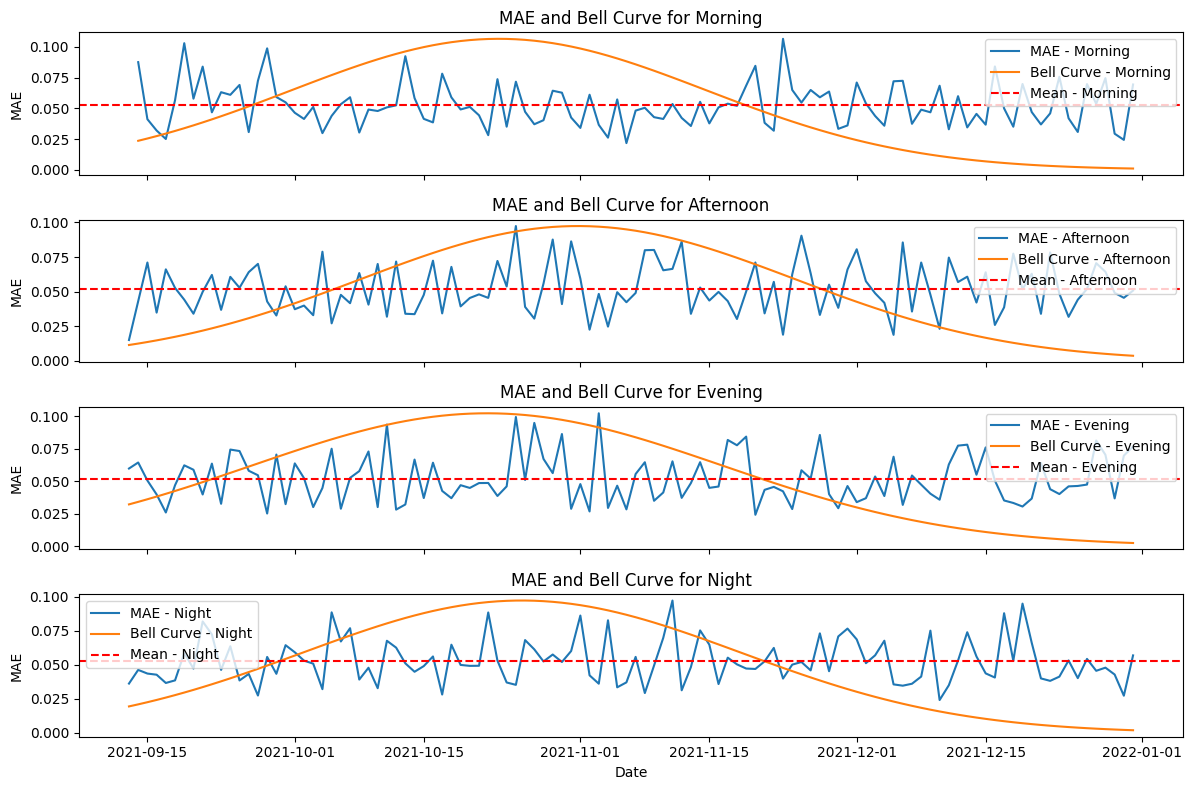

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load the MAE values
file_path = '/content/MAE cluster values.xlsx'
df = pd.read_excel(file_path)

# Convert the 'date' column to datetime format for easier plotting
df['date'] = pd.to_datetime(df['date'])

# Define periods
periods = ['Morning', 'Afternoon', 'Evening', 'Night']

# Create a subplot for each period
fig, axes = plt.subplots(len(periods), 1, figsize=(12, 8), sharex=True)

# Plotting function
def plot_mae(ax, period, data):
    # Filter data for the current period
    period_data = data[data['Period'] == period]

    # Plot MAE values
    ax.plot(period_data['date'], period_data['MAE'], label=f'MAE - {period}')

    # Calculate and plot the bell curve
    mean = period_data['MAE'].mean()
    std = period_data['MAE'].std()
    # Use the length of the date data for x to match dimensions
    x = np.linspace(period_data['MAE'].min(), period_data['MAE'].max(), len(period_data['date']))
    y = norm.pdf(x, mean, std)
    y = y / y.max() * period_data['MAE'].max()  # Normalize the bell curve
    ax.plot(period_data['date'], y, label=f'Bell Curve - {period}')

    # Mark the centroid (mean)
    ax.axhline(mean, color='red', linestyle='--', label=f'Mean - {period}')


    # Customize plot
    ax.set_title(f'MAE and Bell Curve for {period}')
    ax.set_ylabel('MAE')
    ax.legend()

# Plot for each period
for ax, period in zip(axes, periods):
    plot_mae(ax, period, df)

# Finalize the plot
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

In [38]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Load the MAE values from Excel
file_path = '/content/MAE cluster values.xlsx'
df = pd.read_excel(file_path)

# Convert the 'date' column to datetime format for easier manipulation if needed
df['date'] = pd.to_datetime(df['date'])

# Define periods
periods = ['Morning', 'Afternoon', 'Evening', 'Night']

# Initialize dictionaries to store results
results = {'Period': [], 'Mean_MAE': [], 'Std_MAE': []}

# Calculate MAE, standard deviation, and mean for each period
for period in periods:
    period_data = df[df['Period'] == period]
    mae_values = period_data['MAE'].values
    mean_mae = np.mean(mae_values)
    std_mae = np.std(mae_values)

    # Store results
    results['Period'].append(period)
    results['Mean_MAE'].append(mean_mae)
    results['Std_MAE'].append(std_mae)

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Print or use results as needed
print("Period-wise Mean and Standard Deviation of MAE:")
print(results_df)

Period-wise Mean and Standard Deviation of MAE:
      Period  Mean_MAE   Std_MAE
0    Morning  0.052418  0.017620
1  Afternoon  0.051895  0.017718
2    Evening  0.051989  0.018237
3      Night  0.052751  0.015867


<ipython-input-55-879513ffb513>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['datetime'])


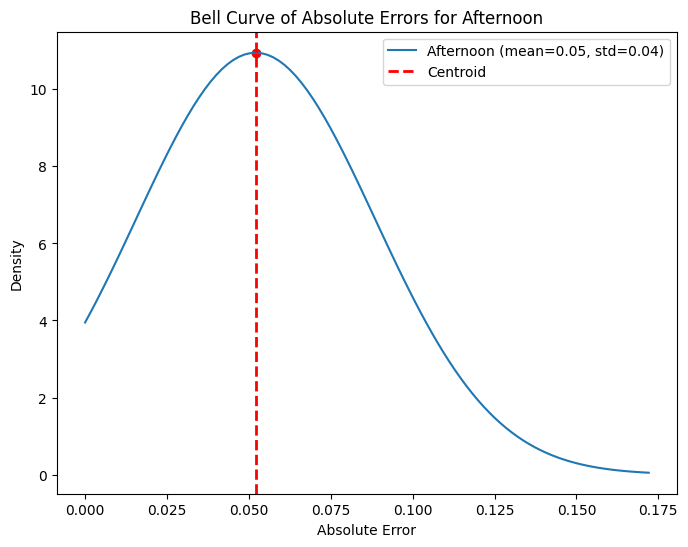

The centroid for Afternoon is at absolute error value 0.05, time: 12:00:00


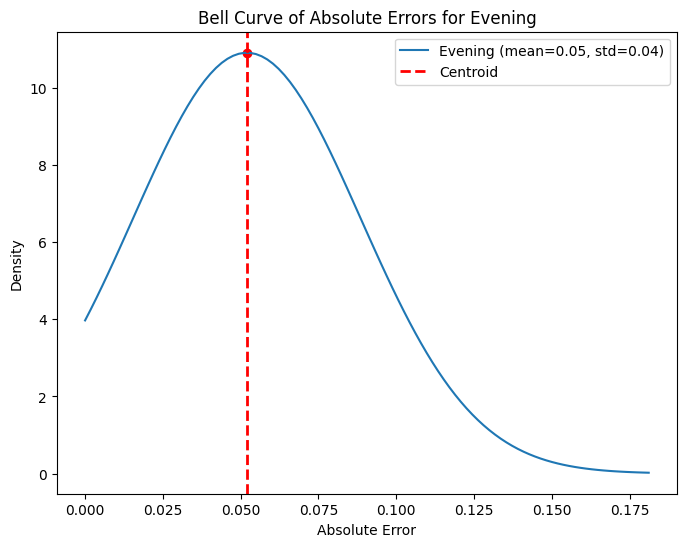

The centroid for Evening is at absolute error value 0.05, time: 17:00:00
No data available for None


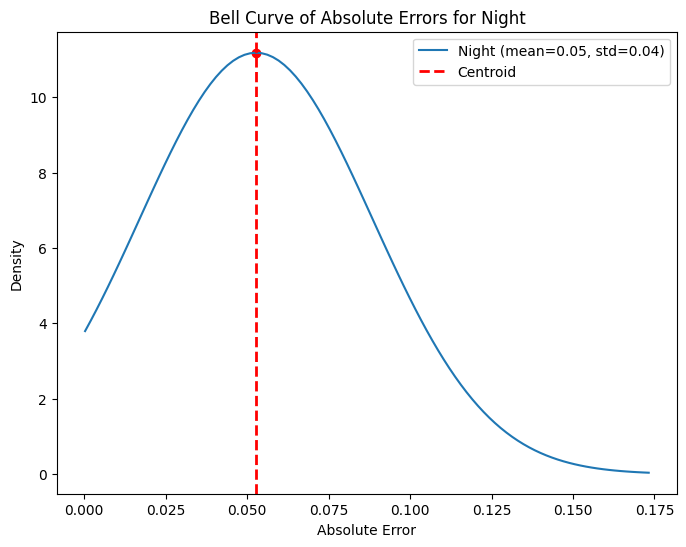

The centroid for Night is at absolute error value 0.05, time: 22:00:00


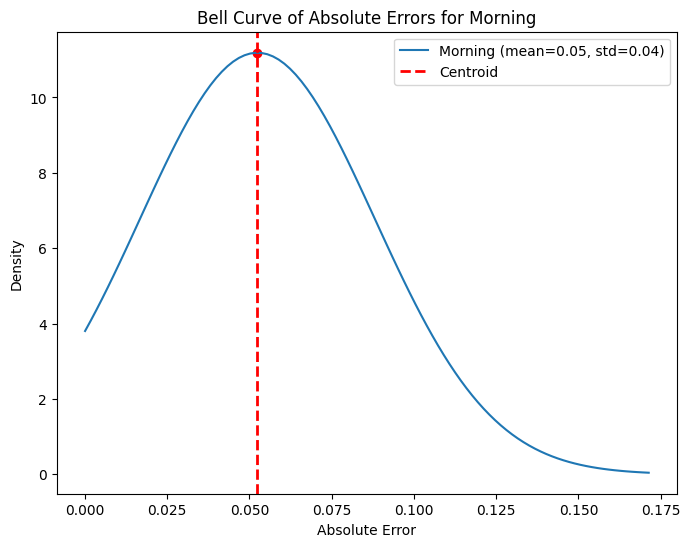

The centroid for Morning is at absolute error value 0.05, time: 04:00:00


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load the Excel file
file_path = '/content/patternpredicted.xlsx'
df = pd.read_excel(file_path)

# Ensure 'datetime' column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Calculate absolute error
df['Absolute Error'] = abs(df['Actual Value'] - df['Predicted value'])

# Define function to determine time of day
def get_time_of_day(hour):
    if 4<= hour <8:
        return 'Morning'
    elif 11<= hour < 15:
        return 'Afternoon'
    elif 15 <= hour <19 :
        return 'Evening'
    elif 20<= hour <=23:
        return 'Night'

# Apply function to create a new column for time of day
df['Time of Day'] = df['datetime'].dt.hour.apply(get_time_of_day)

# Plot bell curves for each time of day segment
time_of_day_segments = df['Time of Day'].unique()

centroids = {}

for time_of_day in time_of_day_segments:
    segment = df[df['Time of Day'] == time_of_day]

    if segment.empty:
        print(f"No data available for {time_of_day}")
        continue

    segment_errors = segment['Absolute Error']
    mean = segment_errors.mean()
    std = segment_errors.std()

    # Store the centroid information
    centroids[time_of_day] = mean

    # Find the closest time instant to the centroid
    closest_time_idx = (segment_errors - mean).abs().idxmin()
    closest_time = df.loc[closest_time_idx, 'datetime']

    # Create a range of values for the x-axis
    x = np.linspace(min(segment_errors), max(segment_errors), 100)

    # Calculate the normal distribution (bell curve)
    p = norm.pdf(x, mean, std)

    # Plot the bell curve
    plt.figure(figsize=(8, 6))
    plt.plot(x, p, label=f'{time_of_day} (mean={mean:.2f}, std={std:.2f})')

    # Highlight the centroid point
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label='Centroid')
    plt.scatter([mean], [norm.pdf(mean, mean, std)], color='r')

    plt.title(f'Bell Curve of Absolute Errors for {time_of_day}')
    plt.xlabel('Absolute Error')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Print the closest time instant to the centroid
    print(f'The centroid for {time_of_day} is at absolute error value {mean:.2f}, time: {closest_time.strftime("%H:%M:%S")}')


In [57]:
import pandas as pd

# Load the data from the Excel file
file_path = '/content/clusters.xlsx'  # Replace with your file path
df = pd.read_excel(file_path)

# Filter the data based on the time of day
morning_data = df[df['time Period'] == 'Morning']
afternoon_data = df[df['time Period'] == 'Afternoon']
evening_data = df[df['time Period'] == 'Evening']
night_data = df[df['time Period'] == 'Night']

# Save the filtered data to new Excel files
morning_data.to_excel('/content/morning cluster.sx.xlsx', index=False)
afternoon_data.to_excel('/content/afternoon cluster.xlsx', index=False)
evening_data.to_excel('/content/evening clusterxlsx.xlsx', index=False)
night_data.to_excel('/content/night cluster.xlsx', index=False)

print("Data has been split and saved into individual files.")

Data has been split and saved into individual files.
